### Importing Libraries

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import shapiro
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(8,6)})

In [0]:
!cp drive/My\ Drive/yapaitek/exported_csv_montreal_tv_locals_after_imputing_missing_data.csv .

1. "Temperature in Montreal during episode" column was imputed by "Multiple Imputations by Chained Equations(MICE) method because more than 5% of data was missing (about 13 percent)



2. There were 43 missing values in Start_time, End_time which are now removed



3. Dataset columns are renamed and formatted 

In [0]:
raw_data = pd.read_csv('exported_csv_montreal_tv_locals_after_imputing_missing_data.csv',index_col=['Id'])
raw_data['Year'] = raw_data['Year'].astype('category')
raw_data.sort_values(['Id']).head(3)

,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Genre,First time or rerun,Number of episode in the season,Movie,Game of the Canadiens during episode,Temperature in Montreal during episode,Market Share_total
Id,,,,,,,,,,,,,,,,,,
0,VidÃ©oclips V,V Total,General Channel,Fall,2016,2016-08-29 00:00:00.000,Monday,2016-08-29 06:00:00.000,2016-08-29 08:00:00.000,8,VidÃ©oclips V,Music Video Clips,No,Yes,No,No,20.400,0.9
1,Apollo dans l'frigo,V Total,General Channel,Fall,2016,2016-08-29 00:00:00.000,Monday,2016-08-29 08:00:00.000,2016-08-29 08:30:00.000,2,Apollo dans l'frigo,Informal Education and Recreation and Leisure,No,Yes,No,No,19.125,0.5
2,InfopublicitÃ©,V Total,General Channel,Fall,2016,2016-08-29 00:00:00.000,Monday,2016-08-29 08:30:00.000,2016-08-29 09:00:00.000,2,InfopublicitÃ©,"Infomercials, Promotional and Corporate Videos",No,Yes,No,No,19.125,0.3


In [0]:
import datetime as dt

# pd.to_datetime(raw_data['Date']).date()
raw_data["quarter"] = pd.to_datetime(raw_data['Date']).dt.quarter
raw_data['quarter'] = raw_data['quarter'].astype('category')

In [135]:
raw_data.describe(include='all')

,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Genre,First time or rerun,Number of episode in the season,Movie,Game of the Canadiens during episode,Temperature in Montreal during episode,Market Share_total,month,quarter
count,616613,616613,616613,616613,616613.0,616613,616613,616613,616613,616613.000000,616613,616613,616613,616613,616613,616613,616613.000000,616613.000000,616613.0,616613.0
unique,6551,24,2,4,4.0,877,7,138321,138333,NaN,6551,27,2,2,2,2,NaN,NaN,12.0,4.0
top,ComplÃ©ment de programme canadien,Teletoon Fr.+,Specialty Channel,Fall,2018.0,2018-02-07 00:00:00.000,Wednesday,2018-02-24 02:00:00.000,2018-09-21 23:00:00.000,NaN,ComplÃ©ment de programme canadien,Animated Television Programs & Films,No,Yes,No,No,NaN,NaN,10.0,4.0
freq,9413,50746,535913,234291,260111.0,840,89726,27,32,NaN,9413,88876,599428,605960,610326,568803,NaN,NaN,65344.0,192577.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.203927,NaN,NaN,NaN,NaN,NaN,NaN,6.707849,3.011577,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.306816,NaN,NaN,NaN,NaN,NaN,NaN,11.326101,4.919651,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-27.425000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.325000,0.400000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.671228,1.400000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,15.575000,3.400000,NaN,NaN


### No missing values!

In [0]:
raw_data.isna().sum()

Episode                                   0
Station                                   0
Channel Type                              0
Season                                    0
Year                                      0
Date                                      0
Day of week                               0
Start_time                                0
End_time                                  0
Length                                    0
Name of show                              0
Genre                                     0
First time or rerun                       0
Number of episode in the season           0
Movie                                     0
Game of the Canadiens during episode      0
Temperature in Montreal during episode    0
Market Share_total                        0
month                                     0
dtype: int64

### Exploring the PDFs 

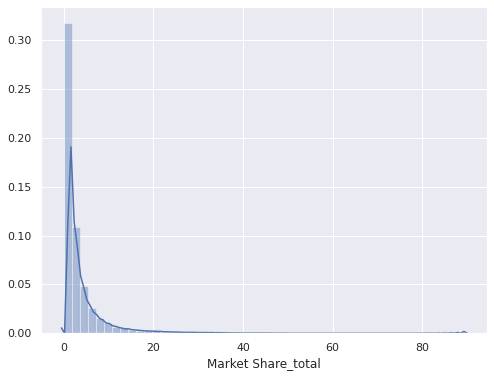

In [136]:
sns.distplot(raw_data['Market Share_total'])

### Dealing with outliers

In [138]:
q = raw_data['Market Share_total'].quantile(0.99)
data_1 = raw_data[raw_data['Market Share_total'] < q]
data_1.describe()

,Length,Temperature in Montreal during episode,Market Share_total
count,610442.000000,610442.000000,610442.000000
mean,3.188439,6.705979,2.705009
std,5.312420,11.328092,3.832859
min,0.000000,-27.425000,0.000000
25%,2.000000,-0.325000,0.400000
50%,2.000000,6.671228,1.400000
75%,4.000000,15.575000,3.300000
max,92.000000,34.950000,26.100000


### Market Share_total

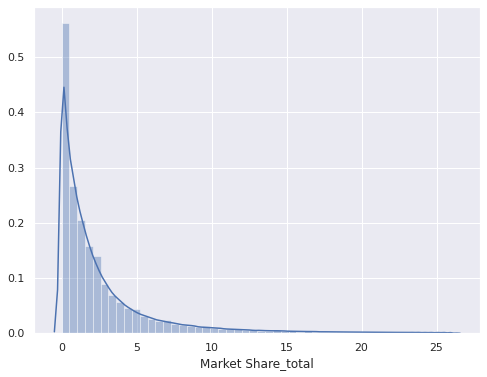

In [139]:
sns.distplot(data_1['Market Share_total'])

### Length

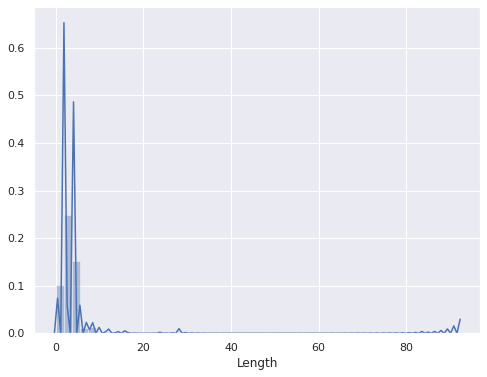

In [140]:
sns.distplot(data_1['Length'])

In [141]:
q = data_1['Length'].quantile(0.99)
data_2 = data_1[data_1['Length'] < q]
data_2.describe()

,Length,Temperature in Montreal during episode,Market Share_total
count,604147.000000,604147.000000,604147.000000
mean,2.773426,6.700082,2.727987
std,2.242164,11.319429,3.844233
min,0.000000,-27.425000,0.000000
25%,2.000000,-0.325000,0.400000
50%,2.000000,6.671228,1.400000
75%,4.000000,15.550000,3.300000
max,23.000000,34.950000,26.100000


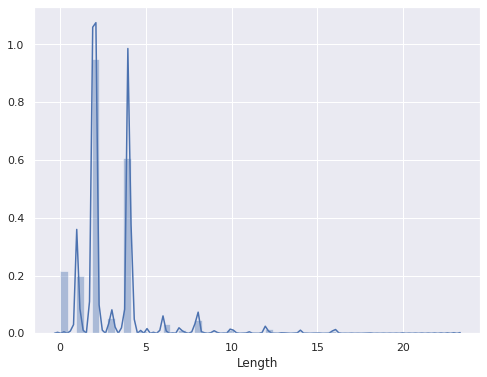

In [142]:
sns.distplot(data_2['Length'])

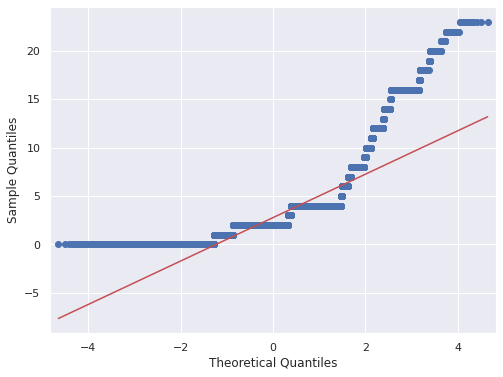

In [143]:
# QQ Plot
from numpy.random import seed
from statsmodels.graphics.gofplots import qqplot
# seed the random number generator
seed(1)
qqplot(data_2["Length"], line='s')
plt.show()

### Done with outliers

In [144]:
data_cleaned = data_2.reset_index(drop=True)
data_cleaned.head()

,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Genre,First time or rerun,Number of episode in the season,Movie,Game of the Canadiens during episode,Temperature in Montreal during episode,Market Share_total,month,quarter
0,Coup de foudre,"MusiquePlus+ (retired Aug 25, 2019)",Specialty Channel,Fall,2018,2018-08-27 00:00:00.000,Monday,2018-08-27 05:30:00.000,2018-08-27 06:00:00.000,2,Coup de foudre,General Entertainment and Human Interest,No,Yes,No,No,20.125,0.0,8,3
1,Coup de foudre,"MusiquePlus+ (retired Aug 25, 2019)",Specialty Channel,Fall,2018,2018-08-27 00:00:00.000,Monday,2018-08-27 06:30:00.000,2018-08-27 07:00:00.000,2,Coup de foudre,General Entertainment and Human Interest,No,Yes,No,No,19.925,0.0,8,3
2,Coup de foudre,"MusiquePlus+ (retired Aug 25, 2019)",Specialty Channel,Fall,2018,2018-08-28 00:00:00.000,Tuesday,2018-08-28 05:30:00.000,2018-08-28 06:00:00.000,2,Coup de foudre,General Entertainment and Human Interest,No,Yes,No,No,21.925,0.0,8,3
3,Coup de foudre,"MusiquePlus+ (retired Aug 25, 2019)",Specialty Channel,Fall,2018,2018-08-28 00:00:00.000,Tuesday,2018-08-28 06:00:00.000,2018-08-28 06:30:00.000,2,Coup de foudre,General Entertainment and Human Interest,No,Yes,No,No,21.525,0.0,8,3
4,Coup de foudre,"MusiquePlus+ (retired Aug 25, 2019)",Specialty Channel,Fall,2018,2018-08-29 00:00:00.000,Wednesday,2018-08-29 05:30:00.000,2018-08-29 06:00:00.000,2,Coup de foudre,General Entertainment and Human Interest,No,Yes,No,No,22.925,0.0,8,3


#### Cleaned data from 616613 -> 597869 rows

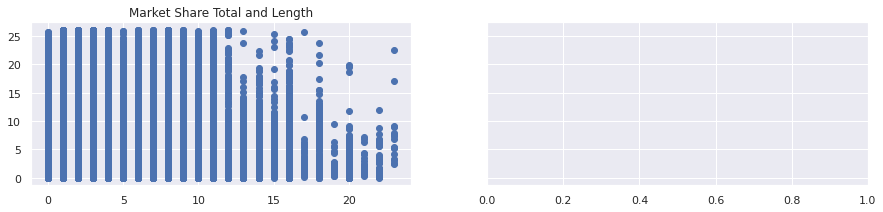

In [145]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,3))
ax1.scatter(data_cleaned["Length"], data_cleaned["Market Share_total"])
ax1.set_title("Market Share Total and Length")
# ax2.scatter(data_cleaned["Temperature in Montreal during episode"], data_cleaned["Market Share_total"])
# ax2.set_title("Market Share Total and Temperature")
plt.show()

### Create Dummy Variables


In [146]:
final_data = data_cleaned[["Station","Year","Length","Market Share_total","Genre","quarter"]]
final_data.head(2)
### can be checked further with "Name of show"


,Station,Year,Length,Market Share_total,Genre,quarter
0,"MusiquePlus+ (retired Aug 25, 2019)",2018,2,0.0,General Entertainment and Human Interest,3
1,"MusiquePlus+ (retired Aug 25, 2019)",2018,2,0.0,General Entertainment and Human Interest,3


In [0]:
data_with_dummies = pd.get_dummies(final_data, drop_first=True)

In [148]:
data_with_dummies.head()

,Length,Market Share_total,Station_Canal D+,Station_Canal Vie+,Station_Evasion+,Station_Historia+,Station_LCN+,Station_MAX+,Station_Meteomedia+,"Station_MusiquePlus+ (retired Aug 25, 2019)",Station_PYC Online Stream Fr CBC-8+,Station_PYC Online Stream Fr CBC-9+,Station_RDI+,Station_RDS+,Station_RDS2+,Station_SRC Total,Station_Series++,Station_TQ Total,Station_TV5+,Station_TVA Total,Station_Teletoon Fr.+,Station_Unis TV+,Station_V Total,Station_VRAK+,Station_Z+,Year_2017,Year_2018,Year_2019,Genre_Analysis and Interpretation,Genre_Animated Television Programs & Films,Genre_Filler,Genre_Formal Education and Pre-School,Genre_Game Shows,Genre_General Entertainment and Human Interest,"Genre_Infomercials, Promotional and Corporate Videos",Genre_Informal Education and Recreation and Leisure,Genre_Interstitial,Genre_Long-form Documentary,Genre_Music Video Clips,Genre_Music Video Programs,Genre_Music and Dance other than Music Video Programs or Clips,Genre_News,Genre_Ongoing Comedy Series (Sitcoms),Genre_Ongoing Dramatic Series,Genre_Other Drama,Genre_Professional Sports,"Genre_Programs of Comedy Sketches, Improvision, Unscripted Works",Genre_Reality Programs,Genre_Religion,Genre_Reporting and Actualities,"Genre_Specials, Mini-Series or Made-for-TV Feature Films",Genre_Theatre Feature Films Aired on TV,Genre_Unknown,Genre_Variety,quarter_2,quarter_3,quarter_4
0,2,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Standardization and train_test Split

In [0]:
target = data_with_dummies["Market Share_total"]
inputs = data_with_dummies.drop(["Market Share_total"],axis=1)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(inputs)
inputs_scaled = scaler.transform(inputs)

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=21)


### Regression Assumptions
. 

### Create the Regression
#### Simple multivariate linear regression 

In [154]:
# poly = PolynomialFeatures(2)
# x_poly = poly.fit_transform(x_train)
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [155]:
reg.score(x_train,y_train)

0.5825208935181836

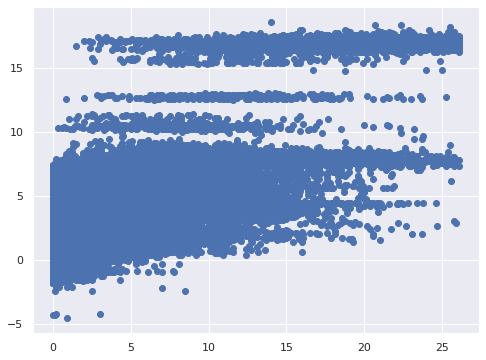

In [156]:
y_hat = reg.predict(x_test)
plt.scatter(y_test,y_hat)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

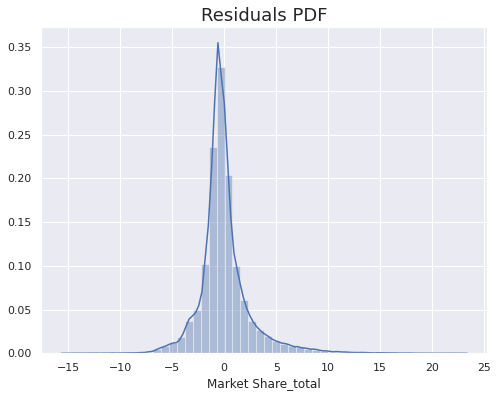

In [157]:
sns.distplot(y_test - y_hat)
plt.title("Residuals PDF", size=18)

In [158]:
y_test = y_test.reset_index(drop=True)
df_pf = pd.DataFrame(y_hat, columns=['Prediction'])
df_pf["Target"] = y_test
df_pf["Residual"] = df_pf["Target"] - df_pf["Prediction"]
df_pf["Difference%"] = np.absolute(df_pf["Residual"]/df_pf["Target"]*100)
df_pf.head()

,Prediction,Target,Residual,Difference%
0,3.774471,4.1,0.325529,7.939739
1,1.736229,3.2,1.463771,45.742841
2,0.906309,2.0,1.093691,54.684544
3,8.045980,6.0,-2.045980,34.099670
4,1.707403,1.0,-0.707403,70.740278


In [159]:
import sklearn.metrics as metrics

mae = metrics.mean_absolute_error(y_test, y_hat)
r2 = metrics.r2_score(y_test,y_hat)

print("MAE:", mae)
print("R-Squared:", r2)

MAE: 1.6026785173979436
R-Squared: 0.5808706984247444


### Other Machine Learning Models

AdaBoostRegressor: 0.437008 (+/- 0.010605)
GradientBoostingRegressor: 0.631952 (+/- 0.002346)
DecisionTreeRegressor: 0.688816 (+/- 0.001597)
RidgeRegressor: 0.582377 (+/- 0.002774)
BayesianRidgeRegressor: 0.582377 (+/- 0.002775)


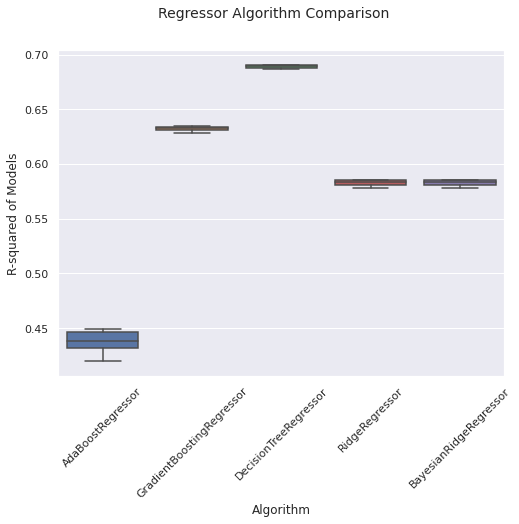

In [151]:
#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score

#Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor


clfs = []

clfs.append(("AdaBoostRegressor",
             Pipeline([("Scaler", StandardScaler()),
                       ("Adaboost", AdaBoostRegressor())]))) 
clfs.append(("GradientBoostingRegressor",
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingRegressor())]))) 

clfs.append(("DecisionTreeRegressor",
             Pipeline([("Scaler", StandardScaler()),
                       ("DART", DecisionTreeRegressor())]))) 

clfs.append(("RidgeRegressor", 
             Pipeline([("Scaler", StandardScaler()),
                       ("Ridge", Ridge())]))) 

clfs.append(("BayesianRidgeRegressor", 
             Pipeline([("Scaler", StandardScaler()),
                       ("BayesianRidge", BayesianRidge())])))


#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'r2'
n_folds = 5

results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds)
    cv_results = cross_val_score(model, x_train, y_train, cv= kfold, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(8,6))
fig.suptitle('Regressor Algorithm Comparison', fontsize=14)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithm", fontsize=12)
ax.set_ylabel("R-squared of Models", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()